# Overview
For this capstone project I will be working on identifying online harassment using NLP.  Why focus on harassment?  Well, for starters, it's a problem that affects a quarter of the population in the U.S.  Additionally, according to a [2021 Pew research poll]( (https://www.pewresearch.org/internet/2021/01/13/the-state-of-online-harassment/)), 79% of respondants "say social media companies are doing an only fair or poor job at addressing online harassment or bullying on their platforms."  Our goal is to construct a virtual moderator, or vMOD, a NLP model that is capable of predicting if a comment is harassment or not, and automatically blocks users who are sending hateful comments.


"Fully 33% of women under 35 say they have been sexually harassed online", For those who identify as LBGTQA, "51% have been targeted for more severe forms of online abuse."

"Among adults who have been harassed online, roughly half of women (47%) say they think they have encountered harassment online because of their gender, whereas 18% of men who have been harassed online say the same. Similarly, about half or more Black (54%) or Hispanic online harassment targets (47%) say they were harassed due to their race or ethnicity, compared with 17% of White targets."


[Plos article](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0221152)


# Data Understanding


Our data comes from a [Kaggle competetion](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data), Identifying Toxic Comments, a dataset comprising of 159571 data points.
measures of central tendency, spread, give broad narrative of data itself.  

How we clean and preprocess our data will have a major effect on the conclusions we can draw

The Natural Language Tool Kit (NLTK) is one of the most popular Python libraries for NLP

Regular Expressions are an important part of NLP, which can be used for pattern matching and filtering

**Feature Engineering** is essential when working with text data, and to understand the dynamics of your text:
* Common feature engineering techniques are removing stop words, stemming, lemmatization, and n-grams
* When diving deeper into grammar and linguistics, context-free grammars and part-of-speech tagging is important
* In this context, parse trees can help computers when dealing with ambiguous words


Then talk about automating process using [Kaggle API key](https://www.kaggle.com/docs/api).

## Import Data
In this section we'll take a preliminary look at our data to get a feel for what we're working with. Let's begin with our import statements and then by taking a look at the contents of our train data directory.

In [3]:
import sys, re, os, csv, codecs, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from google.colab import drive

from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

import shutil

import tensorflow as tf
import tensorflow_hub as hub




In [2]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [3]:
# Get current directory
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'drive', 'sample_data']


In [4]:
# Set path to xrays.  Hint- right click on the file you want to copy file path
drive_path = '/content/drive/MyDrive/Colab_Notebooks/jigsaw-toxic-comment-classification-challenge.zip'


In [5]:
# Navigate to xrays
!cp '{drive_path}' .

In [7]:
# Get current directory/confirm correct path
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'jigsaw-toxic-comment-classification-challenge.zip', 'drive', 'sample_data']


In [6]:
# Unzip
!unzip '/content/jigsaw-toxic-comment-classification-challenge.zip'

Archive:  /content/jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [7]:
# import csv data as pd df
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip')
test_labels= pd.read_csv('test_labels.csv.zip')


## Inspect Data

In [ ]:
train.shape

(159571, 8)

In [ ]:
train.isnull().values.any()


False

In [ ]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
len = train.comment_text.str.len()
print("Shortest comment:", len.min(), "words")
print("Longest comment:", len.max(), "words")
print("Average comment:", len.mean().round(0), "words")




Shortest comment: 6 words
Longest comment: 5000 words
Average comment: 394.0 words


In [8]:
# Lowercase text corpus as we make our train and test dataframes
X_train = train['comment_text'].str.lower()
y_train = train.drop(['id','comment_text'], axis=1)
X_test = test['comment_text'].str.lower()
y_test = test_labels

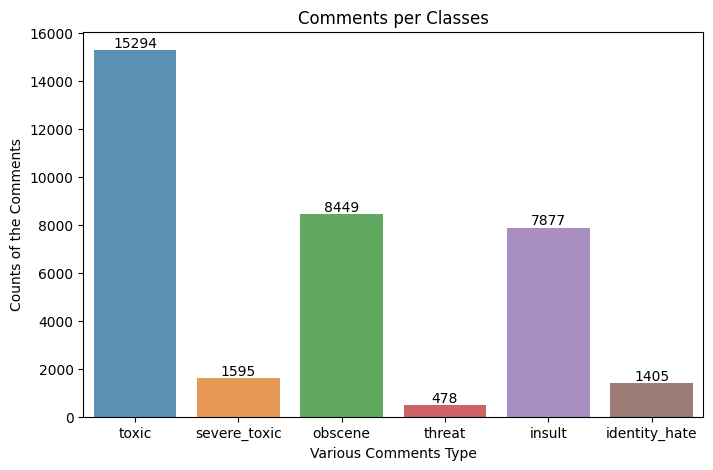

In [11]:
cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

val_counts = y_train[cols].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(x= val_counts.index, y= val_counts.values, alpha=0.8)

plt.title("Comments per Classes")
plt.xlabel("Various Comments Type")
plt.ylabel("Counts of the Comments")

rects = ax.patches
labels = val_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha="center", va="bottom")


plt.show()

In [ ]:
# Find total number of toxic comments in train
x=train.iloc[:,2:].sum()
print("Total number of toxic comments:", x.sum())


Total number of toxic comments: 35098


### Class Imbalance
We can see there is a clear class imbalance in our data-only 35,098 comments are considered toxic, out of our dataset of 159,571; far more records have no toxic languge than do.  We'll need to take this into account when building our model.


# Data Preprocessing

We've already lowercased the letters of our corpus, and now we'll untertake our next step, tokenizing our corpus, or splitting each comment into a series of words.  We'll have to make some decisions now about whether we remove stop words, what kinds of regex expressions we should use to clean the comments, if we should stem, lemmatize, or leave our text data as is before we come to our next step, vectorization.

Because our dataset is quite large, we'll begin by removing stop words.  We'll do this because large datasets become highly dimensionsal after they've been vectorized, and to minimize processing times we'll need to reduce the amount of tokens we pass in to our vector.  Removing stop words- the most common words in english that have little value in this use case, will help us do so.

We'll also use a regex expression to clean up some of the comments.  As we could see in our datatframe, there's many examples of strange punctuation that could adversly affect our model's performance, and we'll want to edit those out as well.

We'll hold off on stemming or lemmatizing for now.  If our results from our initial models are unsatisfactory, we'll circle back to stemming our tokens.

We'll begin with our import statements for this portion of our exploration.

### Notes:
* Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
*Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
* Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
* What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

Another common decision point when working with text data is exactly what features to include in the dataset. As we saw in a previous lab, NLTK makes it quite easy to do things like generate part-of-speech tags for words, or create word or character-level n-grams. In general, there's no great answer for exactly which features will improve the performance of your model, and which won't. This means that your best bet is to experiment, and treat the entire project as an iterative process! When working with text data, don't be afraid to try modeling on alternative forms of the text data, such as bigrams or n-grams. Similarly, we encourage you to explore how adding in additional features such as POS tags or mutual information scores affect the overall model performance.



In [9]:
# Import statements
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import re, string


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
from nltk.stem import PorterStemmer


In [13]:


tokenizer = RegexpTokenizer(r'\w+')
stemmer = PorterStemmer()

def preprocess_text(text):
    # Remove punctuation and "/n"
    text.replace([\W_]+/g," "), '')
    # Tokenize the text using the regex tokenizer
    tokens = tokenizer.tokenize(text)
    # Apply stemming to the tokens
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    # Join the stemmed tokens
    return ' '.join(stemmed_tokens)


SyntaxError: ignored

In [39]:
X_train_cleaned = [preprocess_text(text) for text in X_train]
X_test_cleaned = [preprocess_text(text) for text in X_test]


RecursionError: ignored

In [40]:
# Tokenize words
from nltk.tokenize import RegexpTokenizer

basic_token_pattern = "(r'[^a-zA-Z0–9])"
tokenizer = RegexpTokenizer(basic_token_pattern)

TypeError: ignored

TypeError: ignored

In [17]:
X_train.apply(tokenizer.tokenize)


0         [explanation, why, the, edits, made, under, my...
1         [aww, he, matches, this, background, colour, s...
2         [hey, man, really, not, trying, to, edit, war,...
3         [more, can, make, any, real, suggestions, on, ...
4         [you, sir, are, my, hero, any, chance, you, re...
                                ...                        
159566    [and, for, the, second, time, of, asking, when...
159567    [you, should, be, ashamed, of, yourself, that,...
159568    [spitzer, umm, theres, no, actual, article, fo...
159569    [and, it, looks, like, it, was, actually, you,...
159570    [and, really, don, think, you, understand, cam...
Name: comment_text, Length: 159571, dtype: object

In [25]:
X_test.apply(tokenizer.tokenize)




0         [yo, bitch, ja, rule, is, more, succesful, the...
1         [from, rfc, the, title, is, fine, as, it, is, ...
2                      [sources, zawe, ashton, on, lapland]
3         [if, you, have, look, back, at, the, source, t...
4               [don, anonymously, edit, articles, at, all]
                                ...                        
153159    [totally, agree, this, stuff, is, nothing, but...
153160    [throw, from, out, field, to, home, plate, doe...
153161    [okinotorishima, categories, see, your, change...
153162    [one, of, the, founding, nations, of, the, eu,...
153163    [stop, already, your, bullshit, is, not, welco...
Name: comment_text, Length: 153164, dtype: object

In [18]:
sw = stopwords.words('english')


In [19]:
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stopwords_removed = [token for token in token_list if token not in sw]
    return stopwords_removed

In [20]:
remove_stopwords(X_train)

["explanation\nwhy the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27",
 "d'aww! he matches this background colour i'm seemingly stuck with. thanks.  (talk) 21:51, january 11, 2016 (utc)",
 "hey man, i'm really not trying to edit war. it's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. he seems to care more about the formatting than the actual info.",
 '"\nmore\ni can\'t make any real suggestions on improvement - i wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -i think the references may need tidying so that they are all in the exact same format ie date format etc. i can do that later on, if no-one else does first - if you have any preferences for formatting style on r

In [26]:
remove_stopwords(X_test)

["yo bitch ja rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,",
 '== from rfc == \n\n the title is fine as it is, imo.',
 '" \n\n == sources == \n\n * zawe ashton on lapland —  /  "',
 ":if you have a look back at the source, the information i updated was the correct form. i can only guess the source hadn't updated. i shall update the information once again but thank you for your message.",
 "i don't anonymously edit articles at all.",
 'thank you for understanding. i think very highly of you and would not revert without discussion.',
 'please do not add nonsense to wikipedia. such edits are considered vandalism and quickly undone. if you would like to experiment, please use the sand

**regex** samples
can try these if above does not work

In [ ]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:[’'][a-z]+)?)")


# Vectorization
In order to get these tokens from our documents, we're going to use tools called "vectorizers".  These convert words into numerical representations, allowing computers to build and evaluate machine learning models.  

Vectorization allows our model to:
* Find word predictions
* Find word similarities
* Represent words in a lower-dimensional space
* Allow words with similar meanings to have a similar representation
* Approximate meaning

The most straightforward vectorizer in sklearn.feature_extraction.text is the CountVectorizer, which will simply count the number of each word type in each document.  Two other strategies include:

* Bag of Words: A a simple, yet effective text encoding technique. Corpus is tokenized, only unique words are selected to create the vocabulary and then sorted by alphabetical order.  Single words or n-grams can be used for analysis.


* TF-IDF: Term Frequency–Inverse Document Frequency, is a numerical statistic that’s intended to reflect how important a word is to a document.  This is a slightly more sophisticated version of bag of words.



In [21]:
X_train.shape


(159571,)

In [27]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(X_train)
test_term_doc = vec.transform(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


# Vanilla classifier

In [23]:
model = keras.Sequential([
    keras.layers.Dense(20, activation="tanh"),
    keras.layers.Dense(6, activation="softmax")
])

In [24]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


In [28]:
model_history = model.fit(trn_term_doc,
                          test_term_doc,
                          epochs=5,
                          validation_data=(y_train, y_test))


InvalidArgumentError: ignored

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Bag of Words

In [ ]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2),
                            min_df=2,
                            max_features=1000)
tfidf_vec.fit(x_train)

# trasform train and test
train_tfidf = tfidf_vec.transform(x_train)
test_tfidf = tfidf_vec.transform(x_test)

# Bayes's Theorem
"...with NB models generally
outperforming the sophisticated, structure-sensitive
models explored in recent work. Furthermore, by
combining generative and discriminative classifiers,
we present a simple model variant where an SVM is
built over NB log-count ratios as feature values, and
show that it is a strong and robust performer over all
the presented tasks"

 Multinomial Naive Bayes (MNB) better att snippets.  Support Vector Machine (SVM) better at full length and  SVM with NB(Naive Bayes) features (NBSVM) doing well on both
[Baselines and Bigrams: Simple, Good Sentiment and Topic Classification](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf)



In [ ]:
# Logistic Regression
lr_clf = BinaryRelevance(LogisticRegression( solver='liblinear'))
lr_clf.fit(train_tfidf, y_train)

#naive bayes
nb_clf = BinaryRelevance(MultinomialNB())
nb_clf.fit(train_tfidf, y_train)

# evaluation
lr_eval = eval_fun_br(x_test=test_tfidf, y_test=y_test, classifier=lr_clf)
nb_eval = eval_fun_br(x_test=test_tfidf, y_test=y_test, classifier=nb_clf)
view raw

In [ ]:
mnb = MultinomialNB()

mnb.fit(vec, test_term_doc)
y_hat = mnb.predict(X_val_vec)

precision_score(y_val, y_hat)

# Making things BERT friendly
BERT, which stands for Bidirectional Encoder Representations from Transformers

First let's make the data compliant with BERT:

Column 0: An ID for the row. (Required both for train and test data.)
Column 1: The class label for the row. (Required only for train data.)
Column 2: A column of the same letter for all rows — this is a throw-away column that we need to include because BERT expects it. (Required only for train data.)
Column 3: The text examples we want to classify. (Required both for train and test data.)

We need to split the files into the format expected by BERT: BERT comes with data loading classes that expects two files called train and dev for training. In addition, BERT’s data loading classes can also use a test file but it expects the test file to be unlabelled.


Once the data is in the correct format, we need to save the files as .tsv (BERT doesn't take .csv as input.)



In [ ]:
# A dependency of the preprocessing for BERT inputs
pip install -U "tensorflow-text==2.13.*"

In [ ]:
pip install "tf-models-official==2.13.*"

In [ ]:
# Creating training dataframe according to BERT by adding the required columns
df_bert = pd.DataFrame({
    'id':range(len(train_df)),
    'label':train_df[0],
    'alpha':['a']*train_df.shape[0],
    'text': train_df[1].replace(r'\n', ' ', regex=True)
})

In [ ]:
# Saving dataframes to .tsv format as required by BERT
df_bert_train.to_csv('data/train.tsv', sep='\t', index=False, header=False)
df_bert_dev.to_csv('data/dev.tsv', sep='\t', index=False, header=False)
df_bert_test.to_csv('data/test.tsv', sep='\t', index=False, header=False)

3. Training Model using Pre-trained BERT model
Some checkpoints before proceeding further:

All the .tsv files should be in a folder called “data” in the “BERT directory”.
We should have created a folder “bert_output” where the fine tuned model will be saved.
The pre-trained BERT model should have been saved in the “BERT directory”.
The paths in the command are relative path, “./”
Now, navigate to the directory you cloned BERT into and type the following command:

